<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/bnp_paribas_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Last amended: 04th August, 2021
My folder: C:\Users\ashok\OneDrive\Documents\bnp_paribas_insurance
           /home/ashok/Documents/bnp_paribas_insurance/
Ref:
    Kaggle problem: https://www.kaggle.com/c/bnp-paribas-cardif-claims-management
    https://github.com/catboost/tutorials/blob/master/advanced_tutorials/kaggle_paribas.ipynb

    Catboost documentation:
    https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html

Evaluation:
    logloss
    https://www.kaggle.com/c/bnp-paribas-cardif-claims-management#evaluation

Objectives:
    i)   Learn to work with catboost
    ii)  Plotting missingvalues graphs
            a. Matrix plots
            b. Heatmap/correlation plots
            c. dendogram plots
    ii)  Plotting ROC curve in python
    iii) Feature importance
    iv)  Grid search--parameter tuning

"""


In [1]:
import sklearn
sklearn.__version__

In [ ]:
# 0.1 Update sklearn
! pip install scikit-learn==0.24

In [ ]:
# 0.2 Install catboost
! pip install catboost

In [48]:
# 1.0 Call libraries
#%reset -f
import pandas as pd        # Data manipulation
import numpy as np         # Array manipulation

# 1.1 Modeling libraries
from sklearn.model_selection import train_test_split
# 1.1.1 For parameter-search over grid
from sklearn.model_selection import GridSearchCV
# conda install -c conda-forge catboost 
from catboost import CatBoostClassifier   # For classification
from catboost import Pool                 # Pool is catboost's internal data structure

# 1.2 Model performance
from sklearn.metrics import confusion_matrix, roc_curve,plot_roc_curve,plot_det_curve 
from sklearn.metrics import plot_det_curve 
from sklearn.metrics import f1_score
from sklearn import metrics

# 1.3 For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# 1.4 Plot missing values
#     Ref: https://github.com/ResidentMario/missingno
#     pip install missingno
#     conda install -c conda-forge missingno
import missingno as msno      # For missing plots


# 1.5 Misc
import os
import time
import gc

In [49]:
# 1.6 Display cell outputs from more than one command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [51]:
# 1.7 Connect gdrive
from google.colab import drive  
drive.mount('/gdrive')

Mounted at /gdrive


In [52]:
# 2.0 Where is my data file in gdrive
#     OR in Windows. Specify path to data folder

filePath = "/gdrive/MyDrive/bnp_paribas"
#filePath = "C:/Users/ashok/OneDrive/Documents/bnp_paribas_insurance"


# 2.0.1 Change working directory and read file
os.chdir(filePath)

# 2.1 Read zipped file
#     Zipped file size is 52MB:

train_df = pd.read_csv('train.csv.zip')

In [53]:
# 2.2 Explore data
print(train_df.shape)          # 1,14,321, 133
print()
print(train_df.columns)        # Column names
print()
print(train_df.dtypes)         # Column types
print()

# 2.3 Count of different dtypes
#     float64: 138, object: 19, int64: 6
train_df.dtypes.value_counts()

# 2.3.1 Memory usage
print()
print(train_df.memory_usage().sum())  # 121637672 = 121mb

(114321, 133)

Index(['ID', 'target', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8',
       ...
       'v122', 'v123', 'v124', 'v125', 'v126', 'v127', 'v128', 'v129', 'v130',
       'v131'],
      dtype='object', length=133)

ID          int64
target      int64
v1        float64
v2        float64
v3         object
           ...   
v127      float64
v128      float64
v129        int64
v130      float64
v131      float64
Length: 133, dtype: object



float64    108
object      19
int64        6
dtype: int64


121637672


In [54]:
# 2.4 Distribution of 1 and 0 in target
train_df['target'].value_counts()  # 1: 87021; 0: 27300

1    87021
0    27300
Name: target, dtype: int64

In [55]:
# 2.5 Can we reduce memory usage?
df = train_df.select_dtypes(include = ['float64'])
print(df.max().max())
print(df.min().min())

20.0000009996
-9.99993198897e-07


In [56]:
# 2.5.1 What are the boundaries of float64 and float32?
#       StackOverFlow: https://stackoverflow.com/a/1658752

print(np.finfo('float64'))
print(np.finfo('float32'))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------

Machine parameters for float32
---------------------------------------------------------------
precision =   6   resolution = 1.0000000e-06
machep =    -23   eps =        1.1920929e-07
negep =     -24   epsneg =     5.9604645e-08
minexp =   -126   tiny =       1.1754944e-38
maxexp =    128   max =        3.4028235e+38
nexp =        8   min =        -max
---------------------------------------------------------------



In [57]:
# 2.6 What about int columns?
df = train_df.select_dtypes(include = ['int64'])
print(df.max().max())
print(df.min().min())
int_cols = df.columns
int_cols

228713
0


Index(['ID', 'target', 'v38', 'v62', 'v72', 'v129'], dtype='object')

In [58]:
# 2.6.1 What are the boundaries of int64 and int32?
print(np.iinfo('int64'))
print(np.iinfo('int32'))
print(np.iinfo('int16'))

Machine parameters for int64
---------------------------------------------------------------
min = -9223372036854775808
max = 9223372036854775807
---------------------------------------------------------------

Machine parameters for int32
---------------------------------------------------------------
min = -2147483648
max = 2147483647
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------



In [59]:
# 2.6.2 Transform int64 to int16
train_df[int_cols] = train_df[int_cols].astype('int16')

print("Current memory usage:")
print(train_df.memory_usage().sum())  # 117522116 = 117mb

Current memory usage:
117522116


In [60]:
# 2.7 Just look at few rows of data from 'object' columns
train_df.loc[:20 , train_df.dtypes == "object"]  # All have char data with NaN values

,v3,v22,v24,v30,v31,v47,v52,v56,v66,v71,v74,v75,v79,v91,v107,v110,v112,v113,v125
0,C,XDX,C,C,A,C,G,DI,C,F,B,D,E,A,E,B,O,NaN,AU
1,C,GUV,C,C,A,E,G,DY,A,F,B,D,D,B,B,A,U,G,AF
2,C,FQ,E,NaN,A,C,F,AS,A,B,B,B,E,G,C,B,S,NaN,AE
3,C,ACUE,D,C,B,C,H,BW,A,F,B,D,B,B,B,B,J,NaN,CJ
4,C,HIT,E,NaN,A,I,H,NaN,C,F,B,D,C,G,C,A,T,G,Z
5,C,AYX,A,NaN,A,I,K,DX,A,F,B,D,I,G,C,A,D,X,X
6,C,NFD,E,G,A,C,A,AS,A,F,B,D,E,B,B,B,I,NaN,BJ
7,C,AHBW,D,C,A,I,C,DP,C,F,B,D,C,A,E,A,F,M,BY
8,NaN,GKQ,E,NaN,NaN,D,H,AF,B,B,B,B,P,C,D,C,L,NaN,S
9,C,PYF,C,C,A,I,A,NaN,A,F,B,D,C,A,E,A,J,P,E


In [61]:
# 2.8 Get number of levels in all object columns
df = train_df.loc[: , train_df.dtypes == "object"] 
for i in df.columns:
  print(i, df[i].nunique())

v3 3
v22 18210
v24 5
v30 7
v31 3
v47 10
v52 12
v56 122
v66 3
v71 9
v74 3
v75 4
v79 18
v91 7
v107 7
v110 3
v112 22
v113 36
v125 90


In [62]:
# 3.0 Examine null values
print("Distribution of null values in object data types")
train_df.loc[:, train_df.dtypes == 'object'] \
                                            .isnull() \
                                            .sum()  \
                                            .sort_values(ascending = False)

print("\nDistribution of null values in float data types")
train_df.loc[:, train_df.dtypes == 'float64'] \
                                             .isnull() \
                                             .sum() \
                                             .sort_values(ascending = False)


print("\nDistribution of null values in int data types")
train_df.loc[:, train_df.dtypes == 'int16'] \
                        .isnull() \
                        .sum() \
                        .sort_values(ascending = False)


Distribution of null values in object data types


v30     60110
v113    55304
v56      6882
v3       3457
v31      3457
v22       500
v112      382
v125       77
v52         3
v91         3
v107        3
v74         0
v75         0
v66         0
v79         0
v47         0
v24         0
v110        0
v71         0
dtype: int64


Distribution of null values in float data types


v102    51316
v85     50682
v119    50680
v123    50678
v51     50678
        ...  
v12        86
v50        86
v10        84
v114       30
v14         4
Length: 108, dtype: int64


Distribution of null values in int data types


v129      0
v72       0
v62       0
v38       0
target    0
ID        0
dtype: int64

## Patterns in missing data
Are there patterns in missing data?

In [19]:
# 3.1 It is better and faster to visulaize
#     using a sample:

sample = train_df.sample(frac = 0.1)
sample.shape  # 11432, 133)

(11432, 133)

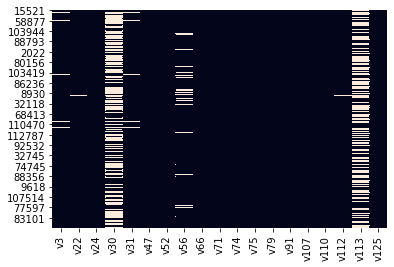

In [20]:
# 3.2 Use seaborn for 'object' features
#     Plot a heatmap of true and false values:

df_sample = sample.loc[:, sample.dtypes=='object' ]
sns.heatmap(df_sample.isnull(), cbar=False);

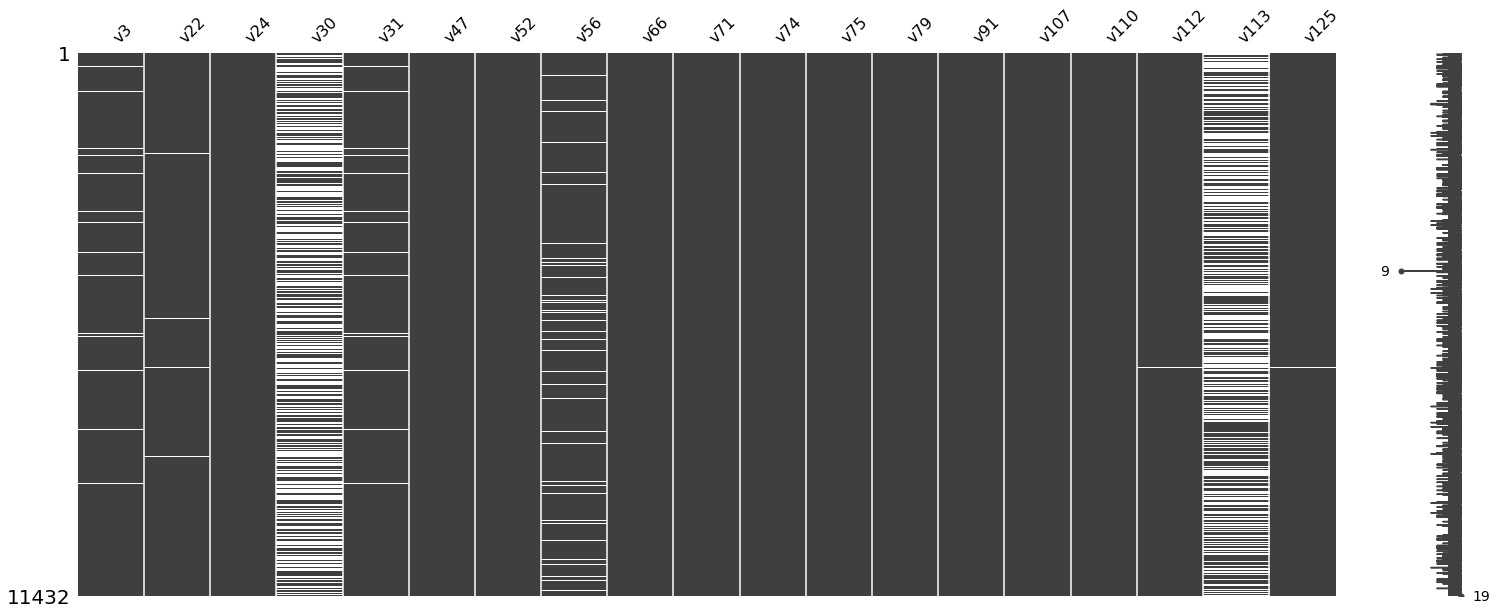

In [63]:
# 3.3 Use missingno package for object features

msno.matrix(df_sample);

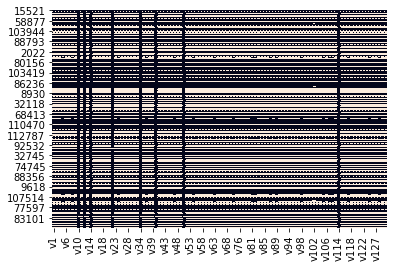

In [22]:
# 3.4 Use seaborn for float features:

sns.heatmap(sample.loc[:, sample.dtypes=='float64' ].isnull(), cbar=False);

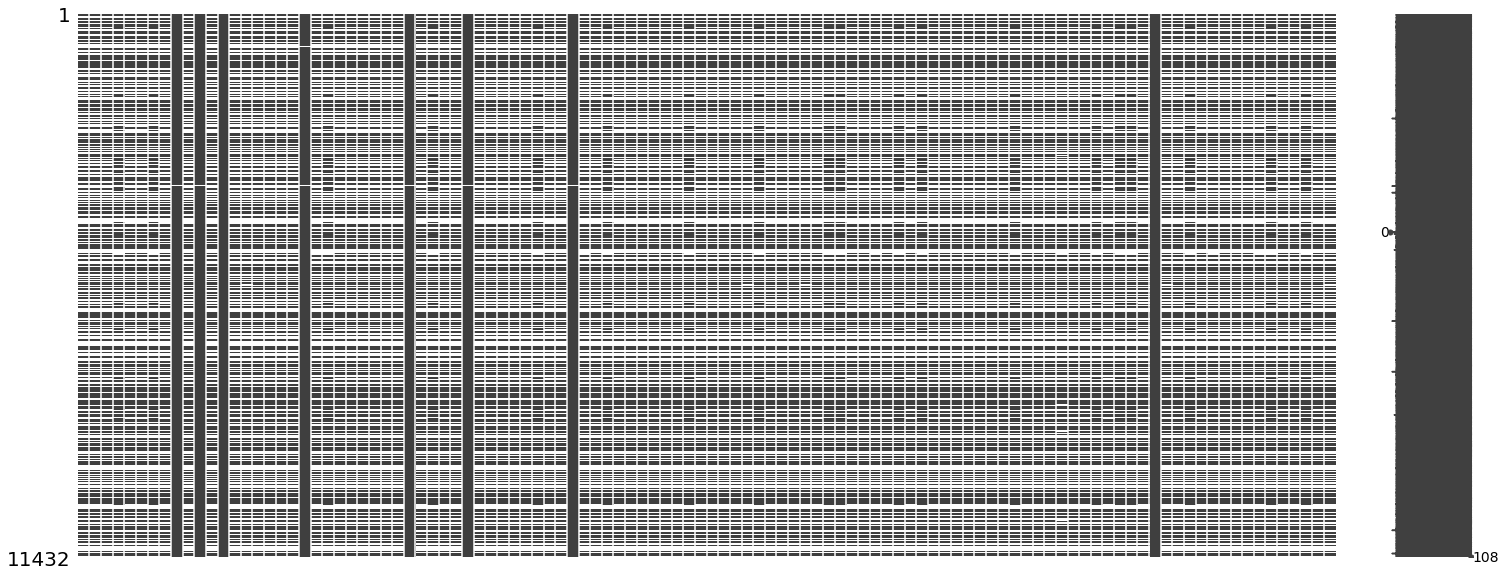

In [64]:
# 3.5 Use missingno for float features
msno.matrix(sample.loc[:, sample.dtypes=='float64' ]);

In [65]:
# 4.0 Fill up missing values:
#     Fill up all just with one value
#     In object type, it will appear as a catageory
#     And in float type, it will be a number

train_df.fillna(-9999, inplace=True)

In [66]:
# 4.1 Just to be sure, check distributon of dtypes again

train_df.dtypes.value_counts()           # fl: 108, Ob: 19, int: 6

float64    108
object      19
int16        6
dtype: int64

In [67]:
# 4.2 Drop columns not needed

X = train_df.drop(axis=1,
                  columns=['ID','target']
                  )

# 3.2 Target
y = train_df.target

In [68]:
# 5. Split data into train/test using train_test_split():

X_train,X_test,y_train,y_test = train_test_split(X,
	                                               y,
	                                               test_size = 0.50   # To save time
	                                             )

# 5.1 Check shapes
X_train.shape   #(57160, 131)
X_test.shape    #(57161, 131)
y_train.shape   # (57160,)
y_test.shape    # (57161,)

(57160, 131)

(57161, 131)

(57160,)

(57161,)

In [70]:
# 5.2 Let us define what we would consider to be
#      a categorical variable and keep a list of
#       all categorical columns
#        We need this list so as to specify in CatBoost

# 5.2.1 First get unique values per col
d_cat = X.apply(pd.Series.nunique)
d_cat                  # Look at them


v1      64488
v2      64525
v3          4
v4      64525
v5      65672
        ...  
v127    64489
v128    65688
v129       10
v130    64477
v131    64415
Length: 131, dtype: int64

In [71]:
# 5.3 Data is anonymous.
#     At times some columns, such as
#     zip-codes etc may have a large number
#     of interger values but are actually 
#     categorical
#     Let us say those columns with
#     unique values < 30000 are categorical
#     np.where() is same as which() in R
#     Note that np.where(d_cat < 30000) is a tuple
#     (array([2,21..]) , ) with first element as
#     an array inside it.
#     Hence the syntax:
#       np.where(d_cat < 30000)[0]  gets the Ist element
#     ie the complete array

d_cat < 30000           # Data being anonymous, an arbitray decision


v1      False
v2      False
v3       True
v4      False
v5      False
        ...  
v127    False
v128    False
v129     True
v130    False
v131    False
Length: 131, dtype: bool

In [72]:
# 5.4
np.where(d_cat < 30000)

(array([  2,  21,  23,  29,  30,  37,  46,  51,  55,  61,  65,  70,  71,
         73,  74,  78,  90, 106, 109, 111, 112, 124, 128]),)

In [73]:
# 5.5 Which are our categorical features?

cat_features_ids = np.where(d_cat < 30000)[0].tolist()
print(cat_features_ids)
len(cat_features_ids)   # 23 in all out of 131

[2, 21, 23, 29, 30, 37, 46, 51, 55, 61, 65, 70, 71, 73, 74, 78, 90, 106, 109, 111, 112, 124, 128]


23

In [75]:
# 5.6 Get list of columns

X.columns[cat_features_ids]

Index(['v3', 'v22', 'v24', 'v30', 'v31', 'v38', 'v47', 'v52', 'v56', 'v62',
       'v66', 'v71', 'v72', 'v74', 'v75', 'v79', 'v91', 'v107', 'v110', 'v112',
       'v113', 'v125', 'v129'],
      dtype='object')

In [76]:
# 5.7
cat = list(train_df.select_dtypes(include = "object").columns.values)
print(cat)

['v3', 'v22', 'v24', 'v30', 'v31', 'v47', 'v52', 'v56', 'v66', 'v71', 'v74', 'v75', 'v79', 'v91', 'v107', 'v110', 'v112', 'v113', 'v125']


In [77]:

"""
5. Start modeling

Ref: https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostclassifier-docpage/
CatBoostClassifier:
      Training and applying models for the
      classification problems. When using
      the applying methods only the probability
      that the object belongs to the class is
      returned. Provides compatibility with the
      scikit-learn tools.

"""
# 6.1 Instantiate the CatBoostClassifier() object

start = time.time()
clf = CatBoostClassifier(
                        learning_rate=0.1,
	                      iterations=300,   #  max no of trees
	                      random_seed=0,
                        thread_count = 2,
                        eval_metric = 'AUC',  # Recall,Precision,F1,TotalF1,
                                              #  Accuracy,Kappa,AUC
	                      verbose =1
	                     )



'\n5. Start modeling\n\nRef: https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostclassifier-docpage/\nCatBoostClassifier:\n      Training and applying models for the\n      classification problems. When using\n      the applying methods only the probability\n      that the object belongs to the class is\n      returned. Provides compatibility with the\n      scikit-learn tools.\n\n'

In [78]:

"""
ref: https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostclassifier_fit-docpage/#python-reference_catboostclassifier_fit
fit
 Train the model
"""

# 6.2 Use now the 'clf' object to learn from data
#     and create model
start = time.time()
clf.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        # Specify which columns are categorical in nature
        cat_features= cat_features_ids  # cat
        )

# Result may say:
#  Shrink model to first 206 iterations.
#    Meaning that out of 300 trees only 206 trees are kept

end = time.time()
(end - start)/60

'\nref: https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostclassifier_fit-docpage/#python-reference_catboostclassifier_fit\nfit\n Train the model\n'

0:	test: 0.7212596	best: 0.7212596 (0)	total: 522ms	remaining: 2m 36s
1:	test: 0.7238319	best: 0.7238319 (1)	total: 1.02s	remaining: 2m 32s
2:	test: 0.7280415	best: 0.7280415 (2)	total: 1.5s	remaining: 2m 28s
3:	test: 0.7304209	best: 0.7304209 (3)	total: 1.99s	remaining: 2m 27s
4:	test: 0.7343292	best: 0.7343292 (4)	total: 2.5s	remaining: 2m 27s
5:	test: 0.7353197	best: 0.7353197 (5)	total: 3s	remaining: 2m 26s
6:	test: 0.7351741	best: 0.7353197 (5)	total: 3.47s	remaining: 2m 25s
7:	test: 0.7353719	best: 0.7353719 (7)	total: 3.94s	remaining: 2m 23s
8:	test: 0.7363889	best: 0.7363889 (8)	total: 4.42s	remaining: 2m 22s
9:	test: 0.7369792	best: 0.7369792 (9)	total: 4.91s	remaining: 2m 22s
10:	test: 0.7371160	best: 0.7371160 (10)	total: 5.36s	remaining: 2m 20s
11:	test: 0.7370987	best: 0.7371160 (10)	total: 5.48s	remaining: 2m 11s
12:	test: 0.7384410	best: 0.7384410 (12)	total: 6s	remaining: 2m 12s
13:	test: 0.7387461	best: 0.7387461 (13)	total: 6.46s	remaining: 2m 12s
14:	test: 0.7386845	

2.4413509805997213

In [79]:
"""
predict
   Apply the model to the given dataset.
   Note. The model can not be correctly
   applied if the order of the columns
   in the testing and training datasets
   differs.
"""

# 6.3  Apply model to make class-wise predictions
prediction = clf.predict(X_test,
                         verbose = True,
                         prediction_type='Class'  # Options: Probability
                         )


'\npredict\n   Apply the model to the given dataset.\n   Note. The model can not be correctly\n   applied if the order of the columns\n   in the testing and training datasets\n   differs.\n'

In [80]:

# 6.4 Apply model to make probaility predictions
#     IInd col of prediction_prob is prob of being '1'.
prediction_prob = clf.predict(X_test,
                              verbose = True,
                              prediction_type='Probability'
                             )



In [81]:

# 6.5 Dataframe of actual vs predicted class-values.
df = pd.DataFrame(
                     {
                     'actualID':y_test,
                     'Predicted':prediction
                     }
                 )
df.head()

,actualID,Predicted
73422,0,1
113056,0,0
30307,1,1
106246,1,1
34636,1,1


In [39]:
# 7.0 Confusion matrix
confusion_matrix(df.actualID,
	               df.Predicted
	             )


array([[ 2836, 10723],
       [ 1363, 42239]])

In [82]:

# 7.1 Calculate performance parameters
#     ravel() flattens the matrix

f1_score(y_test,prediction)


0.8727791250767614

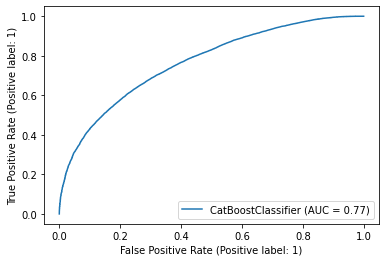

In [83]:

# 7.2 AUC plot
plot_roc_curve(clf,X_test,y_test) ;

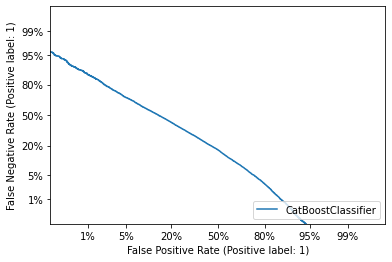

In [84]:
# 7.3
plot_det_curve(clf,X_test,y_test)

In [85]:

# 8.0. Get feature importance
#      First transform data into a special matrix
#      as rquired by catboost

train_pool = Pool(X_train, y_train, cat_features=cat_features_ids)


In [86]:

# 8.1 Calculate feature importance using model object (clf)

feature_importances = clf.get_feature_importance(data=train_pool)
feature_importances
feature_names = X_train.columns


array([4.68004411e-01, 3.88750744e-01, 4.97204619e-01, 3.12845075e-02,
       1.11207337e-01, 4.51942088e-01, 2.39022951e-01, 8.77579987e-02,
       9.67574622e-02, 1.31111514e+00, 3.57480891e-01, 1.40073493e+00,
       1.21653611e-01, 1.00110105e+00, 1.81656583e-01, 2.05455473e-01,
       4.69411248e-02, 6.08219985e-02, 3.64385211e-01, 2.45428192e-01,
       1.62603872e+00, 3.34056610e+00, 2.68877460e-01, 1.83441654e+00,
       4.12897390e-02, 3.30148427e-01, 4.13495000e-02, 5.32103102e-01,
       8.54922746e-02, 9.81687931e-01, 1.70416509e+00, 1.71080141e-01,
       5.44011518e-02, 1.64810759e+00, 2.40385348e-01, 3.87647294e-01,
       1.21011997e-01, 7.77124253e-01, 3.00894998e-01, 2.40743297e+00,
       1.56406653e-02, 2.63184484e-01, 1.13396621e-01, 2.58625206e-01,
       8.45993189e-02, 2.38971102e-01, 3.23396913e+00, 0.00000000e+00,
       3.32440372e-01, 1.82920958e+01, 3.98850813e-01, 3.32092816e+00,
       2.49100430e-01, 0.00000000e+00, 2.35691613e-01, 5.80770011e+00,
      

In [88]:

# 8.2 Create dataframe of feature importance, col-name wise
df_imp = pd.DataFrame(
                       { 'feature_names':feature_names,
                         'feature_impt': feature_importances
                        }
                     ).sort_values(by = 'feature_impt',ascending = False)

df_imp


,feature_names,feature_impt
49,v50,18.292096
65,v66,10.084405
55,v56,5.807700
71,v72,4.717245
21,v22,3.340566
...,...,...
3,v4,0.031285
91,v92,0.025213
40,v41,0.015641
53,v54,0.000000


## How does Catboost encode categorical features?
A demo<br>
Encoding is done as if data is streaming in. We first have one observation, perform encoding. We then have another observation, perform encoding and so on.

See [here](https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html)<br>
And in Moodle, [Excel Sheet](http://203.122.28.230/moodle/mod/resource/view.php?id=4444)


In [90]:
# e1.0
!pip install category_encoders

     |████████████████████████████████| 80 kB 3.5 MB/s 


In [91]:
# e1.1 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [92]:
# e1.2 import libraries
import category_encoders as ce
import pandas as pd


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [93]:
# e 2.0 Make dataset
train = pd.DataFrame({
                       'color': ["red", "blue", "blue", "green", "red",
                                 "red", "black", "black", "blue", "green",
                                 "red", "blue", "green", "red", "blue"],
                      'interests': ["sketching", "painting", "instruments",
                                    "sketching", "painting", "video games",
                                    "painting", "instruments", "sketching",
                                    "sketching", "sketching", "painting",
                                    "sketching", "painting","sketching"],
                      'height': [68, 64, 87, 45, 54, 64, 67, 98, 90, 87,
                                 65,54,78,90,33],
                      'grade':  [1, 0, 1, 0, 0, 1, 1, 0, 1, 1,0,1,1,1,0], 
                      }
                     )


In [94]:
# e 3.0 Define train and target
train.head(10)
target = train[['grade']]
train = train.drop('grade', axis = 1)

,color,interests,height,grade
0,red,sketching,68,1
1,blue,painting,64,0
2,blue,instruments,87,1
3,green,sketching,45,0
4,red,painting,54,0
5,red,video games,64,1
6,black,painting,67,1
7,black,instruments,98,0
8,blue,sketching,90,1
9,green,sketching,87,1


In [95]:
# e 4.0 Define catboost encoder
cbe_encoder = ce.cat_boost.CatBoostEncoder()
  
# e 4.1 Fit encoder and transform the features
cbe_encoder.fit(train, target)
train_cbe = cbe_encoder.transform(train,target)
train_cbe = train_cbe.rename(columns = {"color": "color_e",
                                        "interests" : "interests_e",
                                        "height" : "height_e"}) 

CatBoostEncoder(cols=['color', 'interests'])

### Encoding formula

(**how_many_times_a_feature_was_seen_earlier_with_target_valueOf_1** + prior_value)/Total_number_of times_feature_seen_upto_now

In [96]:
# e5.0
pd.concat([train,
           train_cbe,
           target],
           axis = 1).sort_values(by = 'color', ascending = False) 

,color,interests,height,color_e,interests_e,height_e,grade
0,red,sketching,68,0.600000,0.600000,68,1
4,red,painting,54,0.800000,0.300000,54,0
5,red,video games,64,0.533333,0.600000,64,1
10,red,sketching,65,0.650000,0.720000,65,0
13,red,painting,90,0.520000,0.520000,90,1
3,green,sketching,45,0.600000,0.800000,45,0
9,green,sketching,87,0.300000,0.650000,87,1
12,green,sketching,78,0.533333,0.600000,78,1
1,blue,painting,64,0.600000,0.600000,64,0
2,blue,instruments,87,0.300000,0.600000,87,1


In [ ]:
######### I am done ##########